# Model Garbage Classification
Capstone Kampus Merdeka x Dicoding

[Source](https://www.kaggle.com/mostafaabla/garbage-classification)

# Download Package

In [ ]:
! pip install kaggle

# Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import PIL
import os, sys

# Set up datesets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
local_zip = '/content/drive/MyDrive/Kaggle/datasets/garbage-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/Garbage Classification')
zip_ref.close()

# Check List Directory Datasets

In [ ]:
## check current directory
os.getcwd()

'/content'

In [ ]:
## check list directory datasets
os.listdir('/content/Garbage Classification/garbage_classification')

['paper',
 'biological',
 'metal',
 'green-glass',
 'battery',
 'cardboard',
 'clothes',
 'brown-glass',
 'trash',
 'plastic',
 'shoes',
 'white-glass']

# Check Image

In [16]:
# set up path
import pathlib
data_dir = pathlib.Path('/content/Garbage Classification/garbage_classification')

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total image from this datasets : {image_count}')

Total image from this datasets : 15515


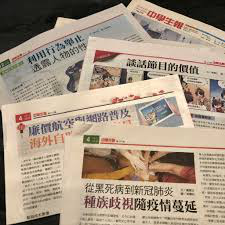

In [17]:
# paper directory
paper = list(data_dir.glob('paper/*'))
PIL.Image.open(str(paper[0]))

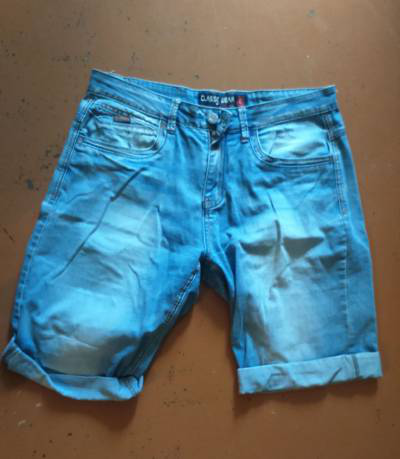

In [18]:
# clothes directory
clothes = list(data_dir.glob('clothes/*'))
PIL.Image.open(str(clothes[10]))

# Split data

In [19]:
# Parameter for spliting
batch_size = 32
img_height = 224
img_width = 224

In [20]:
# Train
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [22]:
class_names_val = val_ds.class_names
print(class_names_val)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


Check Image batch

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# Configure the dataset for performance

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Scaling Image

In [25]:
normalization_layer = layers.Rescaling(1./255)

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Data Augmentation
generate random data

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# EarlyStoping Callbacks

In [29]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    patience = 2, 
    verbose = 1, 
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001, 
    restore_best_weights = True)

callback = [early_stop]

# Create Model CNN

In [30]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [32]:
model.summary()

ValueError: ignored

In [33]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback
)

Epoch 1/15
388/388 [==============================] - 43s 85ms/step - loss: 1.3846 - accuracy: 0.5455 - val_loss: 1.0533 - val_accuracy: 0.6407
Epoch 2/15
388/388 [==============================] - 26s 66ms/step - loss: 0.8492 - accuracy: 0.7178 - val_loss: 0.8661 - val_accuracy: 0.7293
Epoch 3/15
388/388 [==============================] - 25s 64ms/step - loss: 0.6022 - accuracy: 0.7994 - val_loss: 0.8973 - val_accuracy: 0.7270
Epoch 4/15
388/388 [==============================] - 25s 64ms/step - loss: 0.4057 - accuracy: 0.8611 - val_loss: 0.9894 - val_accuracy: 0.7132
Epoch 00004: early stopping


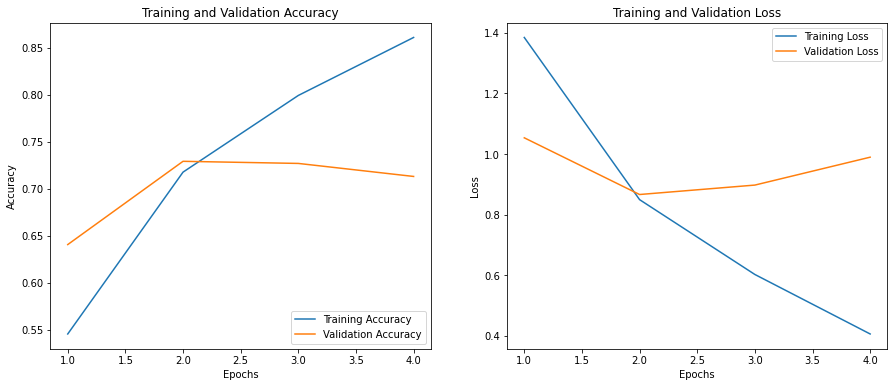

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = np.array([1,2,3,4])

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Import Model Into JSON

In [39]:
!pip install tensorflowjs

     |████████████████████████████████| 64 kB 2.1 MB/s 


In [40]:
# convert into .h5
model.save("models.h5")

In [41]:
!tensorflowjs_converter --input_format keras --output_format=tfjs_graph_model /content/models.h5 /content/json/

2021-12-07 16:58:55.087622: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-07 16:58:55.879064: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-12-07 16:58:56.690642: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25690112 exceeds 10% of free system memory.
2021-12-07 16:58:57.248111: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25690112 exceeds 10% of free system memory.
2021-12-07 16:58:57.341451: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25690112 exceeds 10% of free system memory.
2021-12-07 16:58:57.955088: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25690112 exceeds 10% of free system memory.
2021-12-07 16:58:57.958978: W tensorflow/co